In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import networkx as nx

In [2]:

def plot_feature_connections(alpha, beta):
    """
    Plots the graph showing connections between features x_i, F_i, and H.
    :param alpha: Weights connecting x_i to F_i (2D array).
    :param beta: Weights connecting F_i to H (1D array).
    """
    G = nx.DiGraph()

    # Add nodes for x_i, F_i, and H with 'subset' attribute
    n_x, n_F = alpha.shape
    x_nodes = [(f'x_{i+1}', {'subset': 0}) for i in range(n_x)]
    F_nodes = [(f'F_{i+1}', {'subset': 1}) for i in range(n_F)]
    H_node = ('H', {'subset': 2})
    G.add_nodes_from(x_nodes + F_nodes + [H_node])

    # Add edges with weights for alpha_ji
    for i, (x, _) in enumerate(x_nodes):
        for j, (F, _) in enumerate(F_nodes):
            G.add_edge(x, F, weight=alpha[i, j])

    # Add edges with weights for beta_j
    for j, (F, _) in enumerate(F_nodes):
        G.add_edge(F, 'H', weight=beta[j])

    # Draw the graph
    pos = nx.multipartite_layout(G, subset_key="subset")
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=1000, node_color='lightblue')
    
    # Draw edge labels
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.2)

    plt.title("Connections between Features, F_i, and H")
    plt.show()


# Fixed gamma and varying beta

In [3]:
# Model parameters
n_features = 3
n_x = 2
# alpha = np.random.randint(2, 4, size=(n_x, n_features)) # Random initial alphas
# alpha = np.random.rand(n_x, n_features) # Random initial alphas


B = 10  # Budget

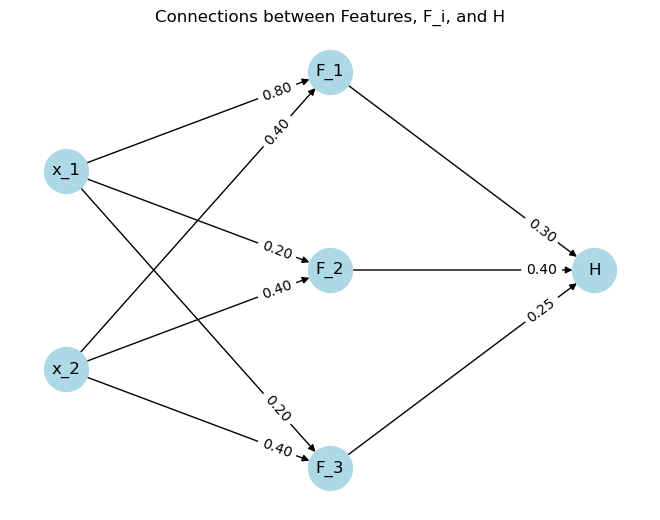

Initial alpha:[[0.8 0.2 0.2]
 [0.4 0.4 0.4]]


In [46]:
beta = np.array([0.3, 0.4, 0.25])
alpha = np.array([[0.8, 0.2, 0.2], [0.4, 0.4, 0.4]])
plot_feature_connections(alpha, beta)
print("Initial alpha:" + str(alpha))

In [47]:
def compute_Fi(x, alpha):
    """
    Computes the F_i values.
    :param x: The x values (array).
    :param alpha: The alpha values (2D array).
    :return: An array of F_i values.
    """
    return np.matmul(alpha.T, x)

def compute_H(Fi, beta):
    """
    Computes the H value.
    :param Fi: The F_i values (array).
    :param beta: The beta values (array).
    :return: The H value.
    """
    return np.dot(beta, Fi)

def objective(x, alpha, beta):
    Fi = compute_Fi(x, alpha)
    return -compute_H(Fi, beta)  # Negative for maximization

# Constraints
constraints = [{'type': 'ineq', 'fun': lambda x: B - np.sum(x)},  # Sum <= B
               {'type': 'ineq', 'fun': lambda x: x}]             # x_i >= 0

# Optimization problem solver
def solve_optimization_problem(alpha, beta):
    x0 = np.full(n_x, B / n_x)  # More balanced initial guess
    result = minimize(objective, x0, args=(alpha, beta), constraints=constraints, bounds=[(0, B) for _ in range(n_x)])
    
    if result.success:
        x_solution = result.x
        x_solution[x_solution < 1e-5] = 0  # Set small values to zero
        return x_solution
    else:
        raise ValueError("Optimization failed")

# Perception adjustment function
def adjust_beta(beta, gamma):
    return np.exp(-(-np.log(beta)) ** gamma)

In [48]:
# # beta = np.array([0.1, 0.9])  # Random initial betas
# # beta /= np.sum(beta)  # Normalize betas
# gamma = 0.1  # Random initial gamma
# n_updates = 5  # Number of times to update beta

# # Updating betas and solving
# x_star_values = np.zeros((n_x, n_updates))
# H_values = np.zeros(n_updates)  # To store H values for each update

# for i in range(n_updates):
#     x_star = solve_optimization_problem(alpha, beta)
#     if x_star is not None:
#         x_star_values[:, i] = x_star
#         Fi = compute_Fi(x_star, alpha)
#         H_values[i] = compute_H(Fi, beta)
#     beta = adjust_beta(beta, gamma)  # Update beta
#     print("\ngamma: " + str(gamma))
#     print("beta: " + str(beta))

# # Plotting
# fig, axes = plt.subplots(n_x, 1, figsize=(10, 3 * n_x))

# for i in range(n_x):
#     # Plot x_i
#     axes[i].plot(range(n_updates), x_star_values[i, :], label=f'x_{i+1}', color='blue')
    
#     # Plot H on the same axes
#     axes[i].plot(range(n_updates), H_values, label='H', color='red', linestyle='--')

#     axes[i].set_title(f"x_{i+1} and H across beta updates")
#     axes[i].set_xlabel("Update number")
#     axes[i].set_ylabel(f"x_{i+1} value")
#     axes[i].legend()

#     # Set ylim for better visibility
#     axes[i].set_ylim(bottom=min(-1, np.min(x_star_values[i, :])), top=max(np.max(x_star_values[i, :]), np.max(H_values)) + 1)

# plt.tight_layout()
# plt.show()


In [49]:
# print("final beta values:", beta)
# print("final H value:", compute_H(compute_Fi(x_star, alpha), beta))
# print("final x values:", x_star)

# Fixed beta and multiple gammas

In [50]:
# Model parameters and functions (same as above)

# Fixed beta
# beta_fixed = np.array([0.1, 0.9])  # Example fixed beta
gamma_values = np.linspace(0, 1, 5)  # Range of gamma values

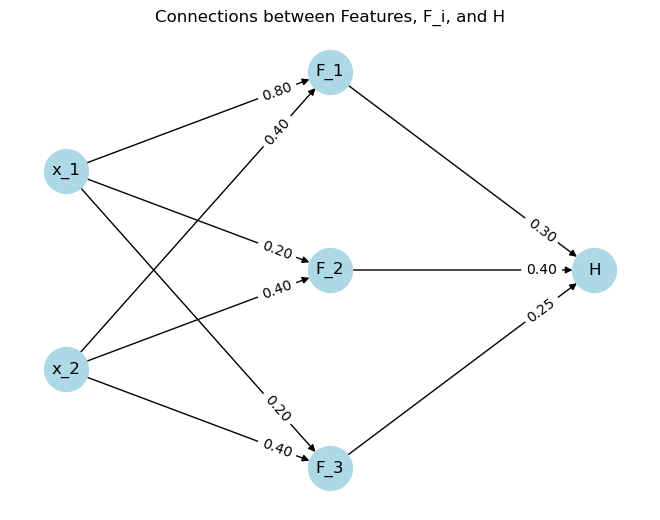

In [51]:
plot_feature_connections(alpha, beta)

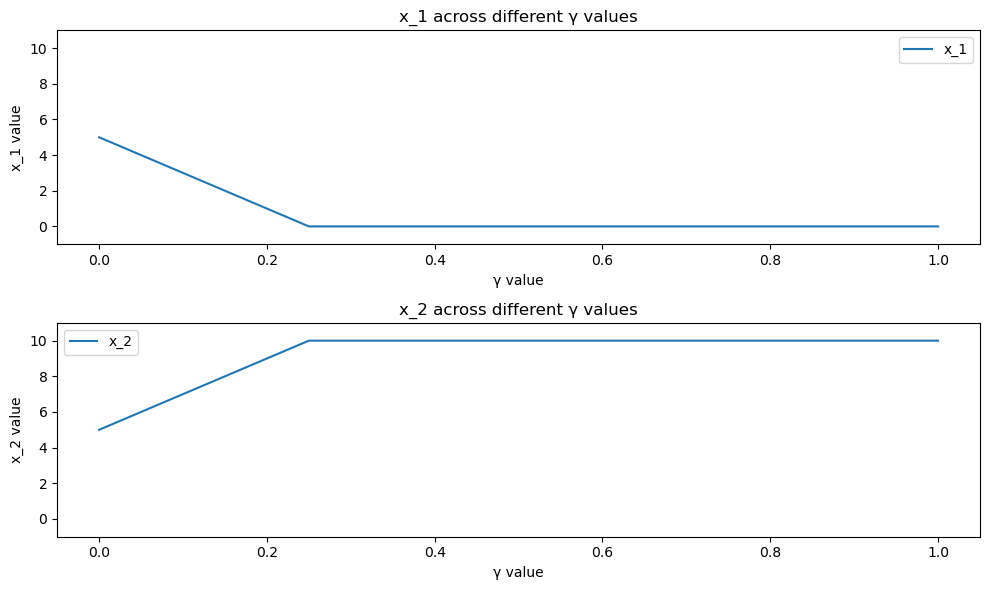

percieved beta values: [0.35422495 0.37431123 0.3438644 ]


In [60]:
# Calculating for multiple gammas
x_star_gamma = np.zeros((n_x, len(gamma_values)))

for idx, gamma in enumerate(gamma_values):
    beta_adjusted = adjust_beta(beta, gamma)
    x_star = solve_optimization_problem(alpha, beta_adjusted)
    if x_star is not None:
        x_star_gamma[:, idx] = x_star

# Plotting
fig, axes = plt.subplots(n_x, 1, figsize=(10, 3 * n_x))

for i in range(n_x):
    axes[i].plot(gamma_values, x_star_gamma[i, :], label=f'x_{i+1}')
    axes[i].set_title(f"x_{i+1} across different γ values")
    axes[i].set_xlabel("γ value")
    axes[i].set_ylabel(f"x_{i+1} value")
    axes[i].legend()
    axes[i].set_ylim(bottom=min(-1, 11), top=max(-1, 11))

plt.tight_layout()
plt.show()



# # Plotting
# fig, axes = plt.subplots(n_x, 1, figsize=(10, 3 * n_x))

# for i in range(n_x):
#     # Plot x_i
#     axes[i].plot(range(n_updates), x_star_values[i, :], label=f'x_{i+1}', color='blue')
    
#     # Plot H on the same axes
#     axes[i].plot(range(n_updates), H_values, label='H', color='red', linestyle='--')

#     axes[i].set_title(f"x_{i+1} and H across beta updates")
#     axes[i].set_xlabel("Update number")
#     axes[i].set_ylabel(f"x_{i+1} value")
#     axes[i].legend()

#     # Set ylim for better visibility
#     axes[i].set_ylim(bottom=min(-1, np.min(x_star_values[i, :])), top=max(np.max(x_star_values[i, :]), np.max(H_values)) + 1)

# plt.tight_layout()
# plt.show()

print("percieved beta values:", adjust_beta(beta, 0.2))

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_13290/1984406583.py:41: RuntimeWarning: divide by zero encountered in log
  return np.exp(-(-np.log(beta)) ** gamma)


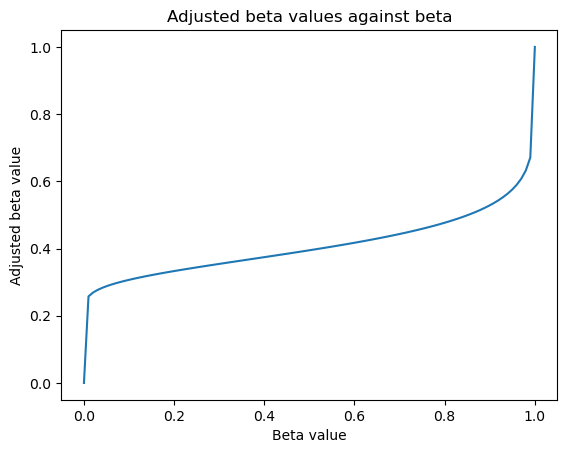